<a href="https://colab.research.google.com/github/acheshkov/text-classification-tutorial/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import pandas as pd
import spacy
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
df = pd.read_csv('./dataset_for_assignment.csv')
df.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [123]:
groups = df.groupby(['target']).agg({'target': 'count'}).to_dict('index')
print(groups[1]['target'], groups[0]['target'])
groups[1]['target'] / groups[0]['target']

16225 143346


0.1131876717871444

0.1131876717871444

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    '''Clean text'''
       
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['comment_text'] = df['comment_text'].apply(clean_text)
df.head()


## Dataset Undersampling

---



In [126]:
indexies_class_0 = df[df.target == 0].index.tolist()
indexies_class_1 = df[df.target == 1].index.tolist()
random_indices_class_0 = np.random.choice(indexies_class_0, len(indexies_class_1), replace=False).tolist()

df_balanced = df.loc[random_indices_class_0 + indexies_class_1]
df_other_class_0 = df.loc[~df.index.isin(random_indices_class_0 + indexies_class_1)]
print(len(df_balanced))
df_balanced.groupby(['target']).agg({'target': 'count'})


32450


,target
target,
0,16225
1,16225


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dfa988550>]],
      dtype=object)

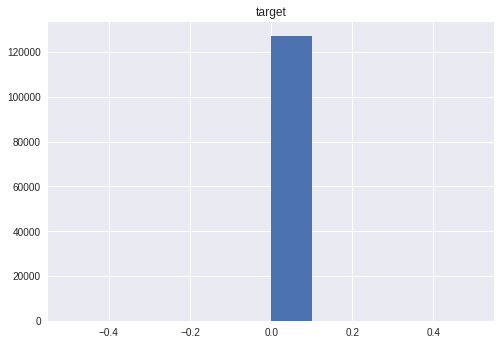

In [128]:
df_other_class_0.hist()

In [133]:
df_train, df_valid = train_test_split(df_balanced, shuffle=True)
X = df_train.comment_text.tolist()
Y = df_train.target.tolist()
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB()),
])

nb.fit(X, Y)

# validation
predicted = nb.predict(df_valid.comment_text.tolist())
np.mean(predicted == df_valid.target.tolist())
print(metrics.classification_report(y_true=df_valid.target.tolist(), y_pred=predicted))


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4097
           1       0.89      0.88      0.88      4016

   micro avg       0.88      0.88      0.88      8113
   macro avg       0.88      0.88      0.88      8113
weighted avg       0.88      0.88      0.88      8113



In [134]:
# C_{ij} is equal to the number of observations known to be in group "i" but predicted to be in group "j".
metrics.confusion_matrix(df_valid.target.tolist(), predicted)





array([[3651,  446],
       [ 502, 3514]])

In [135]:
# validation on class "0" samples that were not incuded in train process
predicted = nb.predict(df_other_class_0.comment_text.tolist())
print("0-1 loss:", np.mean(predicted == df_other_class_0.target.tolist()))
#print(metrics.classification_report(y_true=df_other_class_0.target.tolist(), y_pred=predicted))




0-1 loss: 0.8920241344860409
